# Predictive Maintenance Demonstrator
### Developed by: Mustafa Aldemir & Ahmed Elsenousi

This notebook demonstrates how you can train a model for Predictive Maintenance using a simple LSTM architecture.

Note: The notebook uses a sample dataset provided in the repository. You should collect data from your Predictive Maintenance Demonstrator for an accurate prediction.

![title](images/predmaint1.jpg)

- Greengrass,
- IoT Core
- 

![title](images/architecture.png)


TODO: Update the diagram of the demonstrator and add explanation about how it works

#### Improvement Areas:
- Train in Sagemaker Training Job
- Build a Sagemaker Pipeline
- Automate deployment on Greengrass
- Convert the model to TFLite

### Install required packages

In [7]:
!pip install numpy pandas matplotlib keras --quiet

### Import required packages

In [8]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display, HTML

In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam

### Some constant definitions

In [10]:
RAW_DATA_FILE = 'data/raw_data.csv'
CLEANED_DATA_FILE = 'data/cleaned_data.csv'
MODEL_FILE = 'model/lstm.h5'

In [11]:
# This is the ID of the Greengrass group in the sample dataset.
#Replace it with your own Greengrass Group ID
MY_GREENGRASS_GROUP_ID = "22c680b6-96ab-4e1c-920e-9e1c96df9e31"

In [12]:
MAX_VIBRATION_FLAG = 1

In [13]:
TRAIN_TEST_SPLIT_RATIO = 0.80

### Load the data

In [14]:
# load the dataset to a dataframe
raw_data = pd.read_csv(RAW_DATA_FILE, sep='\t', encoding='utf-8')

In [15]:
# shape of the dataframe
print(f"{raw_data.shape[0]} rows and {raw_data.shape[1]} columns")

# columns
print(f"Columns: {raw_data.columns.values.tolist()}")

2100 rows and 20 columns
Columns: ['zrmsvelocity', 'temperature', 'xrmsvelocity', 'xpeakacceleration', 'zpeakacceleration', 'zrmsacceleration', 'xrmsacceleration', 'zkurtosis', 'xkurtosis', 'zcrestfactor', 'xcrestfactor', 'zpeakvelocity', 'xpeakvelocity', 'zhfrmsacceleration', 'xhfrmsacceleration', 'ts', 'max_vibration', 'motor_speed', 'greengrass_group_id', '__dt']


In [16]:
# display the first rows of the dataframe
raw_data.head()

,zrmsvelocity,temperature,xrmsvelocity,xpeakacceleration,zpeakacceleration,zrmsacceleration,xrmsacceleration,zkurtosis,xkurtosis,zcrestfactor,xcrestfactor,zpeakvelocity,xpeakvelocity,zhfrmsacceleration,xhfrmsacceleration,ts,max_vibration,motor_speed,greengrass_group_id,__dt
0,4.975,32.68,6.314,0.128,0.097,0.107,0.139,2.907,2.737,3.757,3.543,7.035,8.93,0.034,0.027,1.610038e+09,0,40,22c680b6-96ab-4e1c-920e-9e1c96df9e31,2021-01-07 00:00:00.000
1,4.975,32.68,6.314,0.128,0.097,0.107,0.139,2.907,2.737,3.757,3.543,7.035,8.93,0.034,0.027,1.610038e+09,0,40,22c680b6-96ab-4e1c-920e-9e1c96df9e31,2021-01-07 00:00:00.000
2,4.975,32.71,6.314,0.128,0.097,0.107,0.139,2.907,2.737,3.757,3.543,7.035,8.93,0.034,0.027,1.610038e+09,0,40,22c680b6-96ab-4e1c-920e-9e1c96df9e31,2021-01-07 00:00:00.000
3,4.975,32.71,6.314,0.128,0.097,0.107,0.139,2.907,2.737,3.757,3.543,7.035,8.93,0.034,0.027,1.610038e+09,0,40,22c680b6-96ab-4e1c-920e-9e1c96df9e31,2021-01-07 00:00:00.000
4,4.975,32.71,6.314,0.128,0.097,0.107,0.139,2.907,2.737,3.757,3.543,7.035,8.93,0.034,0.027,1.610038e+09,0,40,22c680b6-96ab-4e1c-920e-9e1c96df9e31,2021-01-07 00:00:00.000


### Format the data

In [17]:
raw_data.dropna(subset=['ts'], inplace=True)

In [18]:
raw_data = raw_data.sort_values(by=['ts'])

In [19]:
# raw_data['ts'] = pd.to_datetime(raw_data['ts'], unit='s')

### Get a specific Greengrass Group

In [20]:
# Greengrass groups in the dataset
print(f"Greengrass groups: {raw_data['greengrass_group_id'].unique().tolist()}")

Greengrass groups: ['22c680b6-96ab-4e1c-920e-9e1c96df9e31']


In [21]:
raw_data = raw_data[raw_data['greengrass_group_id'] == MY_GREENGRASS_GROUP_ID]

### Drop unnecessary columns

In [22]:
cleaned_data = raw_data.drop(['__dt','greengrass_group_id'], axis = 1)

### Calculate the remaining time for each row

In [23]:
# https://stackoverflow.com/questions/62819482/efficient-way-of-row-based-calculation-in-pandas/62820025#62820025
cleaned_data['RUL'] = cleaned_data['ts'].where(cleaned_data['max_vibration'].eq(MAX_VIBRATION_FLAG)).bfill()- cleaned_data['ts']

In [24]:
# the last rows have NaN diff
cleaned_data = cleaned_data[cleaned_data['RUL'].notna()]

In [25]:
cleaned_data.head()

,zrmsvelocity,temperature,xrmsvelocity,xpeakacceleration,zpeakacceleration,zrmsacceleration,xrmsacceleration,zkurtosis,xkurtosis,zcrestfactor,xcrestfactor,zpeakvelocity,xpeakvelocity,zhfrmsacceleration,xhfrmsacceleration,ts,max_vibration,motor_speed,RUL
0,4.975,32.68,6.314,0.128,0.097,0.107,0.139,2.907,2.737,3.757,3.543,7.035,8.93,0.034,0.027,1.610038e+09,0,40,301.499058
1,4.975,32.68,6.314,0.128,0.097,0.107,0.139,2.907,2.737,3.757,3.543,7.035,8.93,0.034,0.027,1.610038e+09,0,40,300.222654
2,4.975,32.71,6.314,0.128,0.097,0.107,0.139,2.907,2.737,3.757,3.543,7.035,8.93,0.034,0.027,1.610038e+09,0,40,298.948132
3,4.975,32.71,6.314,0.128,0.097,0.107,0.139,2.907,2.737,3.757,3.543,7.035,8.93,0.034,0.027,1.610038e+09,0,40,297.682250
4,4.975,32.71,6.314,0.128,0.097,0.107,0.139,2.907,2.737,3.757,3.543,7.035,8.93,0.034,0.027,1.610038e+09,0,40,296.415713


### Investigate any anomalies

array([[<Axes: title={'center': 'RUL'}>]], dtype=object)

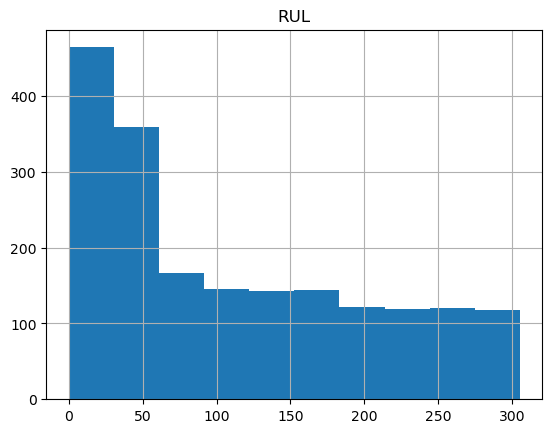

In [26]:
cleaned_data.hist(column='RUL')

In [27]:
# cleaned_data = cleaned_data.drop(cleaned_data[cleaned_data['RUL']>1000].index)

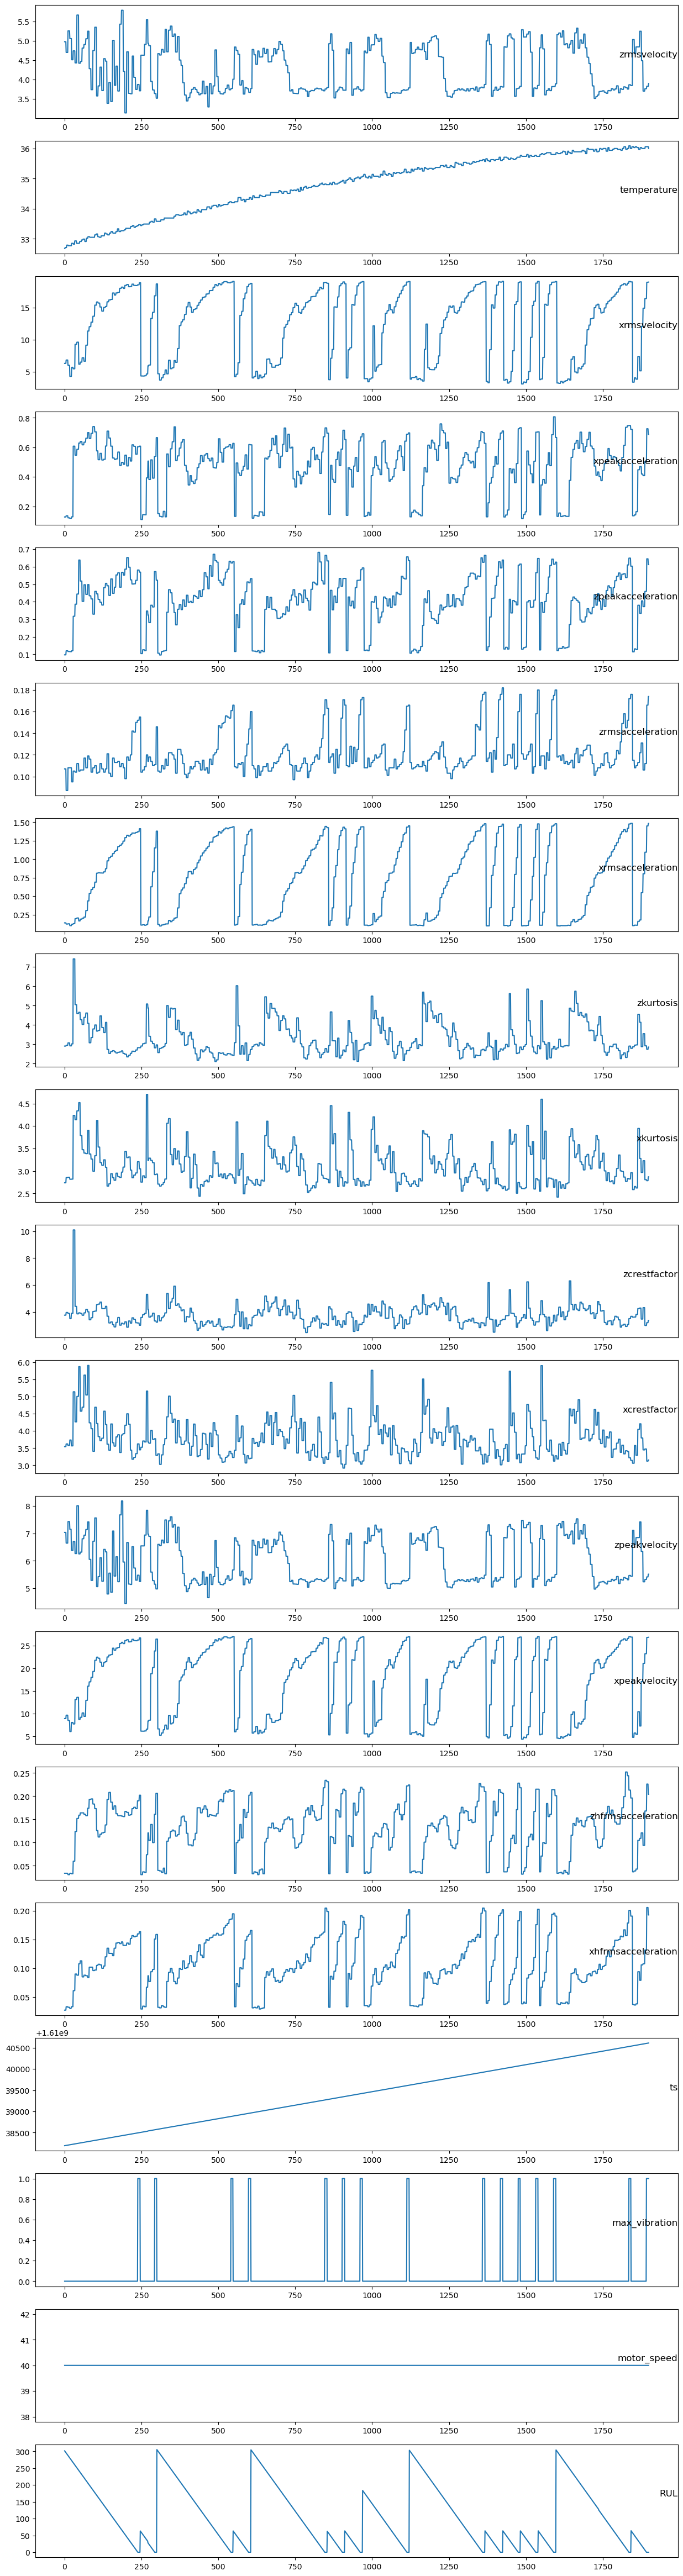

In [28]:
# plot all columns
values = cleaned_data.values

plt.figure(figsize=(15,60))
i = 1
for group in range(cleaned_data.shape[1]):
    plt.subplot(cleaned_data.shape[1], 1, i)
    plt.plot(values[:, group])
    plt.title(cleaned_data.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

### Save in a file

In [29]:
cleaned_data.to_csv(CLEANED_DATA_FILE, sep='\t', index=False, encoding='utf-8')

In [30]:
cleaned_data.shape

(1900, 19)

### Format the data for training

In [31]:
num_steps = 4
# use only these features
used_features = ['zrmsvelocity', 'temperature', 'xrmsvelocity', 'xpeakacceleration',
       'zpeakacceleration', 'zrmsacceleration', 'xrmsacceleration',
       'zkurtosis', 'xkurtosis', 'zcrestfactor', 'xcrestfactor',
       'zpeakvelocity', 'xpeakvelocity', 'zhfrmsacceleration',
       'xhfrmsacceleration']
num_features = len(used_features)

In [32]:
x = np.array(cleaned_data.iloc[:,0:num_features])

In [33]:
used_data_len = len(x) - len(x) % num_steps
x = x[0:used_data_len]

In [34]:
x = np.array(x)
x_shaped = np.reshape(x[0:used_data_len], newshape=(-1, num_steps, num_features))
x_shaped.shape

(475, 4, 15)

In [35]:
y_shaped = np.array(cleaned_data['RUL'][::num_steps])
y_shaped.shape

(475,)

### Split train-test data

In [36]:
TRAIN_TEST_SPLIT_RATIO = 0.80

In [37]:
train_ind = int(TRAIN_TEST_SPLIT_RATIO * x_shaped.shape[0])

x_train = x_shaped[:train_ind]
y_train = y_shaped[:train_ind]
x_test = x_shaped[train_ind:]
y_test = y_shaped[train_ind:]

print(f"Training features shape: {x_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test features shape: {x_test.shape}")
print(f"Test labels shape: {y_test.shape}")

Training features shape: (380, 4, 15)
Training labels shape: (380,)
Test features shape: (95, 4, 15)
Test labels shape: (95,)


### Design the model

In [51]:
# Option 1: The simplest LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(num_steps, num_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
# Option 2: A slightly more complex LSTM model
model = Sequential()
model.add(LSTM(100, activation='tanh', input_shape=(num_steps, num_features), 
               return_sequences=False))
model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=1, activation='linear'))
adam = Adam(lr=0.001)
model.compile(optimizer=adam, loss='mse')

### Train the model

In [52]:
history = model.fit(x_train, y_train, epochs=1000, validation_split=0, verbose=1)

Epoch 1/1000
12/12 [==============================] - 1s 3ms/step - loss: 20401.5352
Epoch 2/1000
12/12 [==============================] - 0s 3ms/step - loss: 18620.5684
Epoch 3/1000
12/12 [==============================] - 0s 3ms/step - loss: 13488.4141
Epoch 4/1000
12/12 [==============================] - 0s 4ms/step - loss: 8369.0820
Epoch 5/1000
12/12 [==============================] - 0s 3ms/step - loss: 6509.7466
Epoch 6/1000
12/12 [==============================] - 0s 3ms/step - loss: 5475.8232
Epoch 7/1000
12/12 [==============================] - 0s 3ms/step - loss: 5167.7231
Epoch 8/1000
12/12 [==============================] - 0s 3ms/step - loss: 4980.1509
Epoch 9/1000
12/12 [==============================] - 0s 3ms/step - loss: 4930.5059
Epoch 10/1000
12/12 [==============================] - 0s 3ms/step - loss: 4854.7939
Epoch 11/1000
12/12 [==============================] - 0s 5ms/step - loss: 4828.0044
Epoch 12/1000
12/12 [==============================] - 0s 3ms/step - lo

### Make predictions and plot

In [55]:
# Make a prediction for a sample point
model.predict(x_train[55].reshape(-1, num_steps, num_features))

1/1 [==============================] - 0s 19ms/step


array([[21.164492]], dtype=float32)

In [54]:
# Make predictions for the full dataset
x_shaped_prediction = model.predict(x_shaped)

15/15 [==============================] - 0s 2ms/step


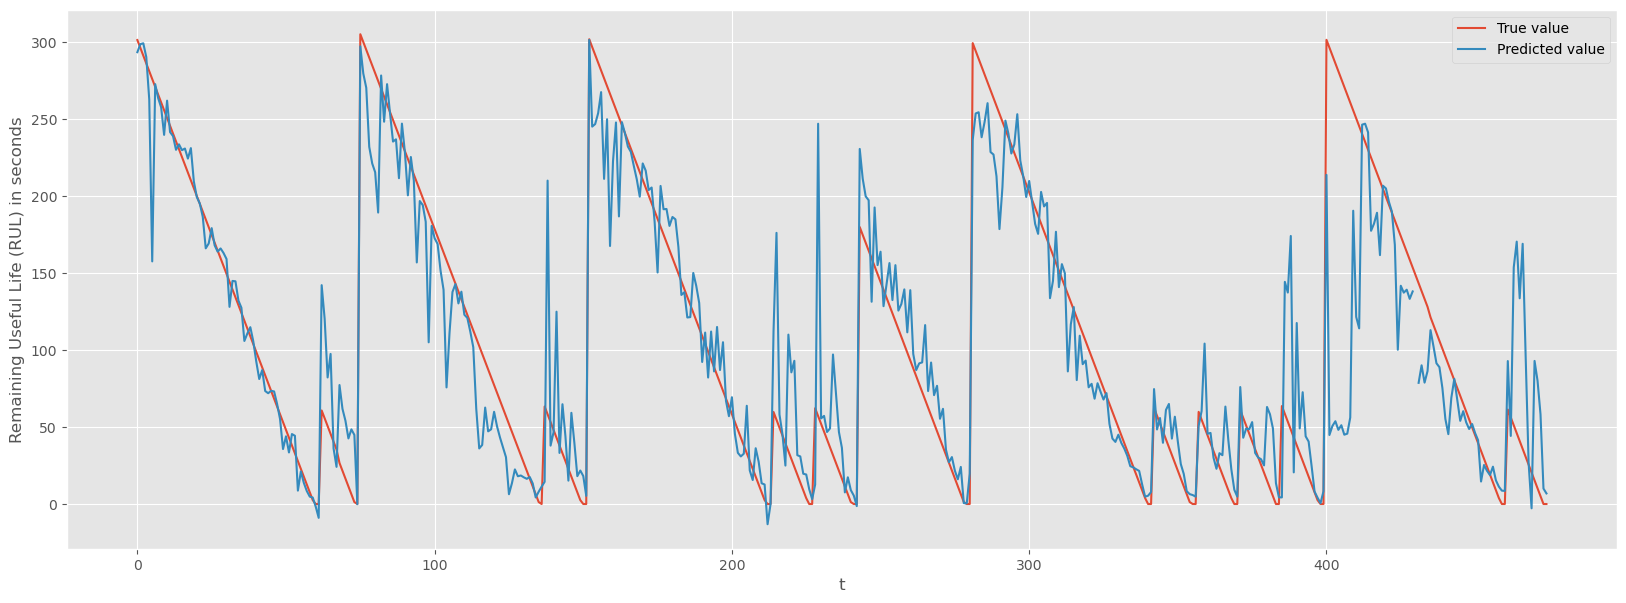

In [61]:
plt.style.use('ggplot')
plt.figure(figsize=(20, 7))
plt.plot(y_shaped, label="True value")
plt.plot(x_shaped_prediction.ravel(), label="Predicted value")
plt.ylabel("Remaining Useful Life (RUL) in seconds")
plt.xlabel("t")
plt.legend()

### Store the model artifacts

In [62]:
model.save(MODEL_FILE)

### Next Steps

Now the trained model is saved as file MODEL_FILE. You can deploy it on Greengrass device to make predictions at the edge.


#TODO: explain how to deploy the model on Greengrass device